In [1]:
from fastai.vision.all import *

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.widgets import FileUpload, ImageClassifierCleaner
sns.__version__


'0.11.1'

In [2]:
path = Path.cwd()/'../datasets/Tomato_leaf'

In [13]:
tomato_leaf = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    item_tfms=Resize(400),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(valid_pct=0.3, seed=42)
)

In [14]:
dls = tomato_leaf.dataloaders(path)

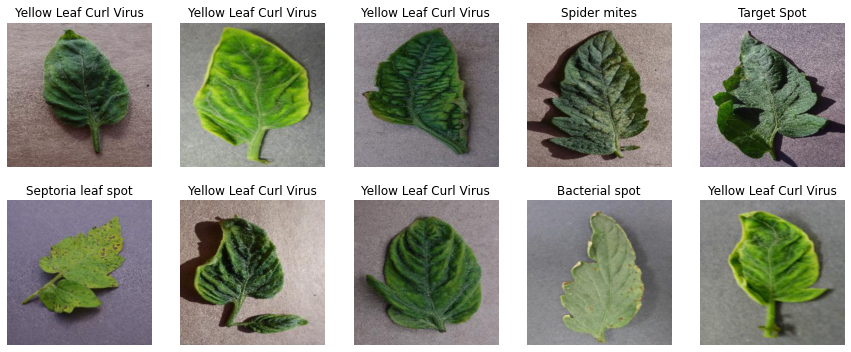

In [15]:
dls.train.show_batch(max_n=10, nrows=2)

In [16]:
model = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])

In [17]:
model.fine_tune(20)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.476568,0.167499,0.059655,0.940345,04:41


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.132173,0.057522,0.018906,0.981094,06:18
1,0.047640,0.045607,0.014501,0.985499,06:17
2,0.041754,0.061504,0.017438,0.982562,06:17
3,0.054870,0.064743,0.017988,0.982012,06:17
4,0.036408,0.061316,0.019090,0.980910,06:17
5,0.043974,0.045476,0.013032,0.986968,06:17
6,0.027200,0.030656,0.008627,0.991373,06:17
7,0.024996,0.027657,0.009728,0.990272,06:17
8,0.021803,0.074245,0.019640,0.980360,06:17
9,0.017075,0.082783,0.020191,0.979809,06:17


In [18]:
interp = ClassificationInterpretation.from_learner(model)

In [19]:
df = pd.DataFrame(data=interp.confusion_matrix(), columns=model.dls.vocab)
df.style.set_properties().background_gradient('YlGnBu')

,Bacterial spot,Early blight,Healthy,Late blight,Leaf Mold,Mosaic virus,Septoria leaf spot,Spider mites,Target Spot,Yellow Leaf Curl Virus
0,633,0,0,0,0,0,0,0,0,0
1,0,281,0,3,0,0,0,0,0,0
2,0,0,472,0,0,0,0,0,0,0
3,0,1,0,573,1,0,0,0,0,0
4,0,1,0,0,313,0,0,0,0,0
5,0,0,0,0,0,129,0,0,0,0
6,0,1,0,0,0,0,525,0,0,0
7,0,0,0,0,0,0,0,476,1,0
8,0,0,0,2,0,0,0,2,420,0
9,0,0,0,0,0,0,0,0,0,1614


In [20]:
path = Path.cwd()/'../models/tomato.pkl'
model.export(path)

In [5]:
learner = load_learner(Path.cwd()/'../models/tomato.pkl')
btn_upload = FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

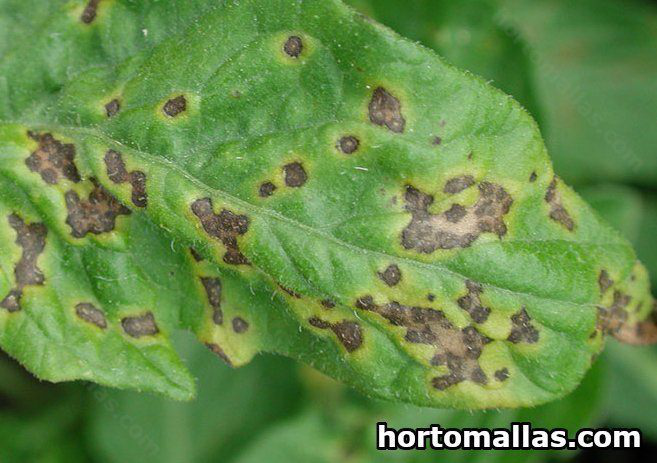

In [16]:
img = btn_upload.data[0]
img = PILImage.create(img)
img


In [17]:
learner.predict(img)

('Septoria leaf spot',
 tensor(6),
 tensor([2.2861e-08, 9.2177e-02, 2.2372e-07, 1.0396e-05, 3.3338e-08, 1.3071e-08,
         9.0781e-01, 1.7417e-11, 2.7540e-08, 5.6007e-11]))

In [1]:
cleaner = ImageClassifierCleaner(model)
clearner

NameError: name 'ImageClassifierCleaner' is not defined

# Testing with Multiblock

In [3]:
def get_y(path): return path.parent.name.split(',')

get_y(get_image_files(path)[0])

['Leaf Mold']

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    splitter=RandomSplitter(seed=42),
    item_tfms= Resize(400),
    get_items= get_image_files,
    get_y = get_y,
    batch_tfms=aug_transforms(flip_vert=True)
)

In [5]:
data = dls.dataloaders(path)

In [39]:
dls.summary(path)

Setting-up type transforms pipelines
Found 18160 items
2 datasets of sizes 14528,3632
Setting up Pipeline: PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/fastai-2020-lalkrishna/My-files/Projects/../datasets/Tomato_leaf/Yellow Leaf Curl Virus/387e6296-d42c-4b9a-b97d-96eaa0d3f531___UF.GRC_YLCV_Lab 01409.JPG
    applying PILBase.create gives
      PILImage mode=RGB size=256x256
  Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}
    starting from
      /home/fastai-2020-lalkrishna/My-files/Projects/../datasets/Tomato_leaf/Yellow Leaf Curl Virus/387e6296-d42c-4b9a-b97d-96eaa0d3f531___UF.GRC_YLCV_Lab 01409.JPG
    applying get_y gives
      [Yellow Leaf Curl Virus]
    applying MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      T

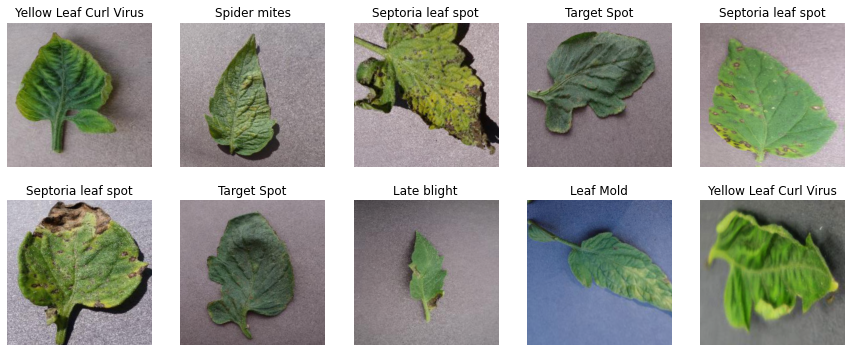

In [6]:
data.train.show_batch(max_n = 10, nrows=2)

In [7]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 400, 400]), torch.Size([64, 10]))

TensorMultiCategory([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], device='cuda:0')

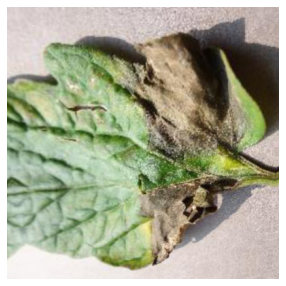

In [8]:
x[3].show();
y[3]

In [9]:
idx = torch.where(y[3] == 1)
data.vocab[idx]

(#1) ['Late blight']

In [10]:
from fastai.callback.fp16 import *

In [19]:
model = cnn_learner(data, resnet18, metrics=partial(accuracy_multi, thresh=0.6))

In [17]:
model.loss_func

FlattenedLoss of BCEWithLogitsLoss()

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.033113110810518265)

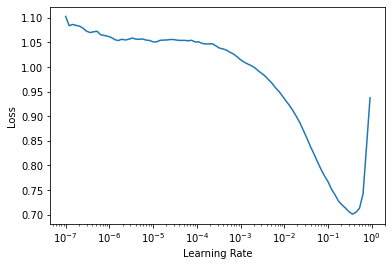

In [13]:
model.lr_find()

In [ ]:
model.fine_tune(15, 1e-13, 2)

epoch,train_loss,valid_loss,accuracy_multi,time
0,1.064697,0.853222,0.605341,03:28
1,1.065671,0.860429,0.601404,03:24


epoch,train_loss,valid_loss,accuracy_multi,time
0,1.065479,0.856645,0.603469,04:20
1,1.072218,0.853075,0.606195,04:18
2,1.065913,0.855726,0.602891,04:19


In [23]:
interp = ClassificationInterpretation.from_learner(model)

,target,predicted,probabilities,loss
0,Septoria leaf spot,Early blight;Healthy;Mosaic virus;Spider mites;Target Spot;Yellow Leaf Curl Virus,"tensor([0.3572, 0.7398, 0.8599, 0.3938, 0.1882, 0.9584, 0.1076, 0.9356, 0.8713,\n 0.7799])",1.6178683042526245
1,Yellow Leaf Curl Virus,Bacterial spot;Early blight;Late blight;Leaf Mold;Mosaic virus;Target Spot,"tensor([0.9161, 0.9018, 0.4332, 0.7423, 0.6803, 0.9194, 0.2744, 0.1037, 0.9555,\n 0.1463])",1.5844742059707642
2,Bacterial spot,Early blight;Healthy;Late blight;Leaf Mold;Spider mites;Target Spot;Yellow Leaf Curl Virus,"tensor([0.3254, 0.7516, 0.6937, 0.8183, 0.8280, 0.3080, 0.4787, 0.9637, 0.6683,\n 0.9575])",1.5759286880493164
3,Target Spot,Bacterial spot;Healthy;Leaf Mold;Mosaic virus;Septoria leaf spot;Spider mites;Yellow Leaf Curl Virus,"tensor([0.8616, 0.0830, 0.9704, 0.4895, 0.6521, 0.5878, 0.9484, 0.5939, 0.0932,\n 0.7209])",1.5715264081954956


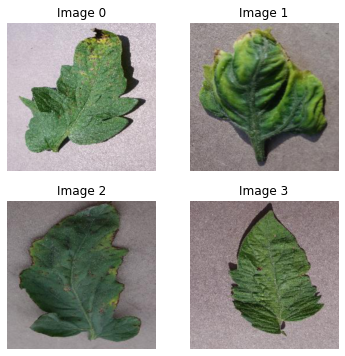

In [25]:
interp.plot_top_losses(4)

In [26]:
pred, targ = model.get_preds()

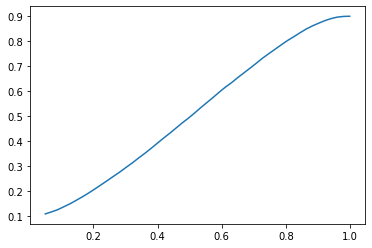

In [44]:
xs = torch.linspace(0.05, 0.999, 50)
acc = [accuracy_multi(pred, targ, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, acc);

In [45]:
model.metrics = partial(accuracy_multi, thresh=0.97)

In [46]:
model.validate()

(#2) [0.8567713499069214,0.897879958152771]

In [41]:
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

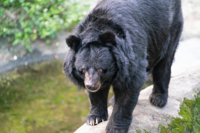

In [47]:
img = PILImage.create(upload.data[0])
img.to_thumb(200)

In [48]:
model.predict(img)

((#5) ['Late blight','Leaf Mold','Mosaic virus','Target Spot','Yellow Leaf Curl Virus'],
 tensor([False, False, False,  True,  True,  True, False, False,  True,  True]),
 tensor([0.2542, 0.2086, 0.4548, 0.5778, 0.5143, 0.7771, 0.4021, 0.2770, 0.7084,
         0.5488]))